# Text classification method performance evaluation using the IMDB movie review dataset

## Package imports

In [ ]:
# using https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671 as base code for most of the notebook

# All imports
# Data manipulation and NNetworks
import tensorflow as tf
import pandas as pd
import numpy as np
# File manipulation
import os
import shutil
# plotting
import matplotlib.pyplot as plt
# Time
import time




## Data import

In [ ]:
# Download dataset from repository
URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(fname="aclImdb_v1.tar.gz", 
                                  origin=URL,
                                  untar=True,
                                  cache_dir='.',
                                  cache_subdir='')

84140032/84125825 [==============================] - 2s 0us/step


In [ ]:
# Create main directory path ("/aclImdb")
main_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
# Create sub directory path ("/aclImdb/train")
train_dir = os.path.join(main_dir, 'train')
# Remove unsupervised folder
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)
# View the final train folder
print(os.listdir(train_dir))

['pos', 'labeledBow.feat', 'neg', 'urls_pos.txt', 'unsupBow.feat', 'urls_unsup.txt', 'urls_neg.txt']


## Data split train/test 80/20

In [ ]:
# We create a training dataset and a validation 
# dataset from our "aclImdb/train" directory with a 80/20 split for training and testing.
train = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, validation_split=0.2, 
    subset='training', seed=123)

test = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, validation_split=0.2, 
    subset='validation', seed=123)

# Use the "test" directory for validation
valid = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, seed=123)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
# Training set
for i in train.take(1):
  train_feat = i[0].numpy()
  train_lab = i[1].numpy()

train = pd.DataFrame([train_feat, train_lab]).T
train.columns = ['Data', 'Label']
train['Data'] = train['Data'].str.decode("utf-8")
# sanity check
#print(train.head())
print(train.shape)

(20000, 2)


In [ ]:
# Test set
for j in test.take(1):
  test_feat = j[0].numpy()
  test_lab = j[1].numpy()

test = pd.DataFrame([test_feat, test_lab]).T
test.columns = ['Data', 'Label']
test['Data'] = test['Data'].str.decode("utf-8")
# sanity check
#print(test.head())
print(test.shape)


(5000, 2)


In [ ]:
# Validation set
for j in valid.take(1):
  valid_feat = j[0].numpy()
  valid_lab = j[1].numpy()

valid = pd.DataFrame([valid_feat, valid_lab]).T
valid.columns = ['Data', 'Label']
valid['Data'] = valid['Data'].str.decode("utf-8")
# sanity check
#print(valid.head())
print(valid.shape)

(25000, 2)


## Dataset exploration

In [ ]:
df_expl = pd.concat([train, test, valid], ignore_index = True)

print(df_expl['Label'].value_counts())
print(train['Label'].value_counts())
print(test['Label'].value_counts())
print(valid['Label'].value_counts())

1    25000
0    25000
Name: Label, dtype: int64
0    10057
1     9943
Name: Label, dtype: int64
1    2557
0    2443
Name: Label, dtype: int64
1    12500
0    12500
Name: Label, dtype: int64


The dataset is balanced for the two classes and for each split of the data. There is no strong imbalance that justifies a different sampling of the data.

In [ ]:
# Dataset statistics
# max length of review (word and character)
print('Max string length of review: ', round(np.max(df_expl['Data'].apply(lambda x: len(x)))))
print('Max word length of review: ', round(np.max(df_expl['Data'].apply(lambda x: len(x.split())))))
# min length of review (word and character)
print('Min string length of review: ', round(np.min(df_expl['Data'].apply(lambda x: len(x)))))
print('Min word length of review: ', round(np.min(df_expl['Data'].apply(lambda x: len(x.split())))))
# avg length of review (word and character)
print('Mean string length of review: ', round(np.mean(df_expl['Data'].apply(lambda x: len(x)))))
print('Mean word length of review: ', round(np.mean(df_expl['Data'].apply(lambda x: len(x.split())))))

Max string length of review:  13704
Max word length of review:  2470
Min string length of review:  52
Min word length of review:  10
Mean string length of review:  1325
Mean word length of review:  234


There is a large spread between the minimum and the maximum number of words or string length in this dataset. We will visualize the distribution in terms of word length of reviews to better the dataset. Visualizing word length makes more sense as stop words (usually short) are still included at this moment. We shall also visualize the distribution of reviews by word length depending on the class (positive or negative review).

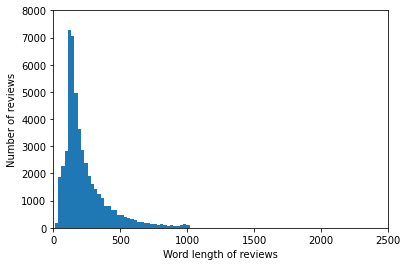

In [ ]:
# Plot distribution of reviews by word length
plt.hist([len(t.split()) for t in df_expl['Data']], 100)
plt.xlabel('Word length of reviews')
plt.ylabel('Number of reviews')
plt.rcParams["figure.figsize"] = (18.5,10.5)
plt.xlim(0,2500)
plt.ylim(0, 8000)
plt.show()

The distribution is heavily skewed towards 200-300 word length as expected, with long reviews being rare. This is somewhat expected as these movie reviews can be submitted to IMDB by any user. We will now see if this distribution is also present for each class.

In [ ]:
# negative reviews
neg_rev = df_expl[df_expl['Label'] == 0]['Data']
# positive reviews
pos_rev = df_expl[df_expl['Label'] == 1]['Data']

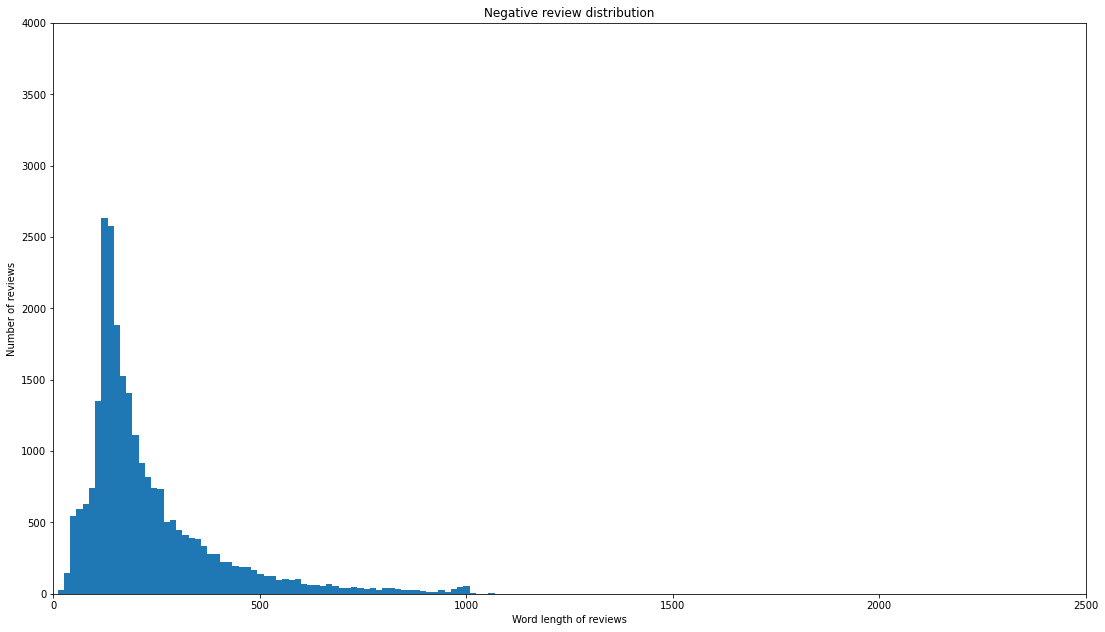

In [ ]:
# plot negative review distribution by word length

plt.hist([len(t.split()) for t in neg_rev], 100)
plt.xlabel('Word length of reviews')
plt.ylabel('Number of reviews')
plt.rcParams["figure.figsize"] = (18.5,10.5)
plt.xlim(0,2500)
plt.ylim(0, 4000)
plt.title('Negative review distribution')
plt.show()

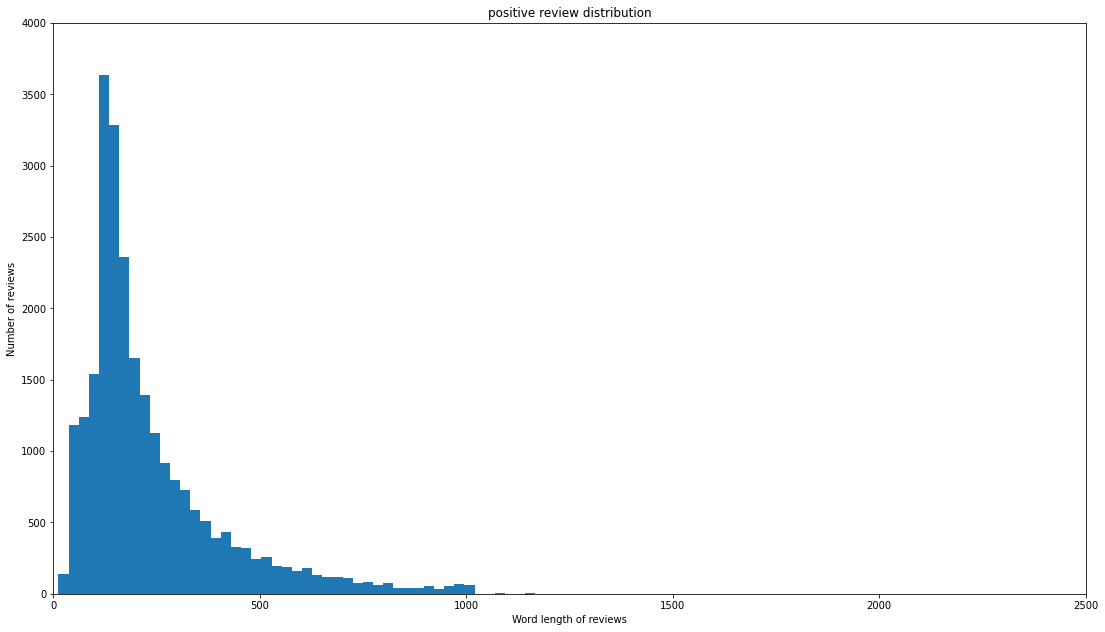

In [ ]:
# plot negative review distribution by word length

plt.hist([len(t.split()) for t in pos_rev], 100)
plt.xlabel('Word length of reviews')
plt.ylabel('Number of reviews')
plt.rcParams["figure.figsize"] = (18.5,10.5)
plt.xlim(0,2500)
plt.ylim(0, 4000)
plt.title('positive review distribution')
plt.show()

These distributions are interesting to compare to one another. We can see that the number of words used for a negative distribution seems to be more numerous for very short text (< 100 words) and also for text longer than for the review average length. The distribution of negative reviews is heavier around the average than for the positive reviews. The latter's distribution decays faster. We shall check the similar word/string average statistics used previously for positive and negative reviews.

In [ ]:
# Dataset statistics
# Negative reviews
# max length of review (word and character)
print('#######################################################')
print('Negative reviews statistics')
print('Max string length of review: ', round(np.max(neg_rev.apply(lambda x: len(x)))))
print('Max word length of review: ', round(np.max(neg_rev.apply(lambda x: len(x.split())))))
# min length of review (word and character)
print('Min string length of review: ', round(np.min(neg_rev.apply(lambda x: len(x)))))
print('Min word length of review: ', round(np.min(neg_rev.apply(lambda x: len(x.split())))))
# avg length of review (word and character)
print('Mean string length of review: ', round(np.mean(neg_rev.apply(lambda x: len(x)))))
print('Mean word length of review: ', round(np.mean(neg_rev.apply(lambda x: len(x.split())))))

print('########################################################')
print('positive reviews statistics')
print('Max string length of review: ', round(np.max(pos_rev.apply(lambda x: len(x)))))
print('Max word length of review: ', round(np.max(pos_rev.apply(lambda x: len(x.split())))))
# min length of review (word and character)
print('Min string length of review: ', round(np.min(pos_rev.apply(lambda x: len(x)))))
print('Min word length of review: ', round(np.min(pos_rev.apply(lambda x: len(x.split())))))
# avg length of review (word and character)
print('Mean string length of review: ', round(np.mean(pos_rev.apply(lambda x: len(x)))))
print('Mean word length of review: ', round(np.mean(pos_rev.apply(lambda x: len(x.split())))))

#######################################################
Negative reviews statistics
Max string length of review:  8969
Max word length of review:  1522
Min string length of review:  52
Min word length of review:  10
Mean string length of review:  1303
Mean word length of review:  231
########################################################
positive reviews statistics
Max string length of review:  13704
Max word length of review:  2470
Min string length of review:  70
Min word length of review:  12
Mean string length of review:  1347
Mean word length of review:  237


Except for the maximum length, that might be an outlier, the average length of both positive and negative reviews are similar to each other. This underlines the importance of the distribution visualization as it gives more insight into the data

## Text normalization

We now wish to remove text contractions, stop words, special characters, parse HTML text and lemmatize the text

In [ ]:
# Example
example = df_expl['Data'][0]
# print(example)

examples = df_expl['Data'][0:4]
examples

0    Canadian director Vincenzo Natali took the art...
1    I gave this film 10 not because it is a superb...
2    I admit to being somewhat jaded about the movi...
3    For a long time, 'The Menagerie' was my favori...
Name: Data, dtype: object

In [ ]:
# Imports for text normalization
import spacy
import nltk
nltk.download('stopwords')
import re
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Text tokenizer
tokenizer = ToktokTokenizer()
stopwords = nltk.corpus.stopwords.words('english')
nlp = nlp = spacy.load("en_core_web_sm")

In [ ]:
# The following text normalization functions are inspired from: https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews


# Define necessary functions

# remove html
def strip_html(text):
  soup = BeautifulSoup(text, "html.parser")
  return soup.get_text()

# remove brackets
def remove_brackets(text):
  return re.sub('\[[^]]*\]', '', text)

# remove special characters
def remove_special_chara(text):
  pattern = r'[^a-zA-z0-9\s]'
  text = re.sub(pattern,'',text)
  return text

# lower case
def lower_case(text):
  text = text.lower()
  return text 

# remove new lines \n
def remove_new_line(text):
  text = re.sub(r'[\r|\n|\r\n]+', ' ',text)
  return text

# stem word endings
def stemmer(text):
  ps = nltk.porter.PorterStemmer()
  text = ' '.join([ps.stem(word) for word in text.split()])
  return(text)

# lemmatization
def lemmatize_text(text):
  text = nlp(text)
  text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
  return text

# remove stop words
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [ ]:
# function to normalize text

def text_normer(text):
  text = text.apply(strip_html)
  text = text.apply(remove_brackets)
  text = text.apply(remove_special_chara)
  text = text.apply(lower_case)
  text = text.apply(remove_new_line)
  # Unexpected results
  # text = text.apply(stemmer)
  text = text.apply(lemmatize_text)
  text = text.apply(remove_stopwords)
  return text

In [ ]:
# Test on example
normalization_test = text_normer(examples)
print(normalization_test[0])

canadian director vincenzo natali take arthouse circuit storm intriguing astonishingly intelligent cube personal favourite sf film 90 frame basic conceit group stranger trap maze shape like giant cube shoot entirely one set take idea fascinating direction eagerly await natalis followup although take five year mount another project delighted say worth wait cypher fascinating exploration one man place world completely logical chain event find situation beyond controli want reveal much plot one joy cypher different avenue take refreshing day age see sf film one idea head cypher filmmorgan sullivan jeremy northam one blandest people ever walk planet hire company digicorp send different part america record different seminar bewilderment unbelievably bore cover topic mundane shaving cream cheesewhile morgan wait one seminar run rita foster impeccably cast lucy liu definition ice maiden give brushoff something find irresistible surprising consider dry marriage rita turn another one morgans se

We can now normalize our data and save it for future use.

In [ ]:
# tic = time.time()
# normalized_train = text_normer(train['Data'])
# print(f"Time to normalize training data (20k rows): {time.time() - tic:.2f} s")


In [ ]:
# normalized_train.head()

In [ ]:
# normalize test data
# tic = time.time()
# normalized_test = text_normer(test['Data'])
# print(f"Time to normalize test data (5k rows): {time.time() - tic:.2f} s")

In [ ]:
# normalize validation data
# tic = time.time()
# normalized_valid = text_normer(valid['Data'])
# print(f"Time to normalize validation data (25k rows): {time.time() - tic:.2f} s")

In [ ]:
# # Collect data in appropriate dataframes and save
# # training data
# df_norm_train = pd.DataFrame().assign(Data = normalized_train, Label = train['Label'])
# # test data
# df_norm_test = pd.DataFrame().assign(Data = normalized_test, Label = test['Label'])
# # validation data
# df_norm_valid = pd.DataFrame().assign(Data = normalized_valid, Label = valid['Label'])

# # save everything as CSV
# df_norm_train.to_csv('normalized_train.csv', index = False)
# df_norm_test.to_csv('normalized_test.csv', index = False)
# df_norm_valid.to_csv('normalized_valid.csv', index = False)

In [ ]:
# load back data
df_train = pd.read_csv('normalized_train.csv')
df_test = pd.read_csv('normalized_test.csv')
df_valid = pd.read_csv('normalized_valid.csv')

## Baseline comparison

We compare how the different baseline methods (Logistic Regression, Ranfom Forest Classifier and Support Vector Machines) perform accuracy-wise and time wise using two different sparse vectorization for feature extraction (CountVectorizer and Tfidfvectorizer)

In [ ]:
# Vectorizer imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


In [ ]:
# The following code is inspired from the code implementation for the last question of Lab2 (text classification lab) and 
# https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html

# LogisticRegression Pipeline
pipe_lr = Pipeline([
    ("countVectorizer", CountVectorizer()),
    ("LogisticRegression", LogisticRegression(multi_class="multinomial", max_iter=100))])

# RandomForestClassifier Pipeline
pipe_rf = Pipeline([
    ('countVectorizer', CountVectorizer()),
    ('RandomForestClassifier', RandomForestClassifier(random_state=0))])

# SVC
pipe_svm = Pipeline([
    ('countVectorizer', CountVectorizer()),
    ('SVM', SVC(random_state=0))])


# Define pipeline parameters for all models
params_lr = {
    "countVectorizer__ngram_range": [(1,1), (1,2)],
    "countVectorizer__binary": [True, False],
    "LogisticRegression__C": [0.5, 1.0],
    #"LogisticRegression__solver": ["newton-cg", "lbfgs"],
    #"LogisticRegression__warm_start": [True, False]
}

params_rf = {
    "countVectorizer__ngram_range": [(1,1), (1,2)],
    "countVectorizer__binary": [True, False],
    "RandomForestClassifier__criterion": ["gini", "entropy"],
    #"RandomForestClassifier__bootstrap": [True, False],
    #"RandomForestClassifier__warm_start": [True, False]
}

params_svm = {
    "countVectorizer__ngram_range": [(1,1), (1,2)],
    "countVectorizer__binary": [True, False],
    "SVM__kernel": ["linear", "rbf", "sigmoid"], 
    #"SVM__C": [0.5, 1.0]
}

grid_param_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=params_lr,
    scoring='accuracy',
    cv=3) 

grid_param_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=params_rf,
    scoring="accuracy",
    cv=3)

grid_param_svm = GridSearchCV(
    estimator=pipe_svm,
    param_grid=params_svm,
    scoring="accuracy",
    cv=3)

pipelines = [(grid_param_lr, params_lr, pipe_lr), (grid_param_rf, params_rf, pipe_rf), (grid_param_svm, params_svm, pipe_svm)]

In [ ]:
from pprint import pprint
from time import time
import warnings

warnings.filterwarnings('ignore')
##### runtime ended prematurely (restarting at failure)
# pipelines = [(grid_param_svm, params_svm, pipe_svm)]
#####
for pipe in pipelines:
    print("Performing grid search...")
    print("Pipeline:", [name for name, _ in pipe[2].steps])
    print("Parameters:")
    pprint(pipe[1])
    t0 = time()
    pipe[0].fit(df_train["Data"], df_train["Label"])
    print("Done in %0.3fs\n" % (time() - t0))
    print("Best score: %0.3f" % pipe[0].best_score_)
    print("Best parameters set:")
    best_parameters = pipe[0].best_estimator_.get_params()
    for param_name in sorted(pipe[1].keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    # On training data
    predict_train = pipe[0].best_estimator_.predict(df_train["Data"])
    # On test data
    predict_test = pipe[0].best_estimator_.predict(df_test["Data"])

    # classification report for optimal parameters (training set)
    print("\nClassification report for optimal parameters (training set)\n")
    print(classification_report(df_train["Label"], predict_train))

    # classification report for optimal parameters (test set)
    print("\nClassification report for optimal parameters (test data)\n")
    print(classification_report(df_test["Label"], predict_test))
    
    print("################################################################")

    ## The result shown below is the attempt at 3-fold cross validation

Performing grid search...
Pipeline: ['countVectorizer', 'LogisticRegression']
Parameters:
{'LogisticRegression__C': [0.5, 1.0],
 'countVectorizer__binary': [True, False],
 'countVectorizer__ngram_range': [(1, 1), (1, 2)]}
Done in 756.006s

Best score: 0.880
Best parameters set:
	LogisticRegression__C: 1.0
	countVectorizer__binary: False
	countVectorizer__ngram_range: (1, 2)

Classification report for optimal parameters (training set)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10057
           1       1.00      1.00      1.00      9943

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


Classification report for optimal parameters (test data)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2443
           1       0.89      0.89      0.89      2557

    accurac

In [ ]:
### output for 5-fold CV

# Performing grid search...
# Pipeline: ['countVectorizer', 'LogisticRegression']
# Parameters:
# {'LogisticRegression__C': [0.5, 1.0],
#  'countVectorizer__binary': [True, False],
#  'countVectorizer__ngram_range': [(1, 1), (1, 2)]}
# Done in 1827.272s

# Best score: 0.883
# Best parameters set:
# 	LogisticRegression__C: 1.0
# 	countVectorizer__binary: False
# 	countVectorizer__ngram_range: (1, 2)

# Classification report for optimal parameters (training set)

#               precision    recall  f1-score   support

#            0       1.00      1.00      1.00     10057
#            1       1.00      1.00      1.00      9943

#     accuracy                           1.00     20000
#    macro avg       1.00      1.00      1.00     20000
# weighted avg       1.00      1.00      1.00     20000


# Classification report for optimal parameters (test data)

#               precision    recall  f1-score   support

#            0       0.88      0.88      0.88      2443
#            1       0.89      0.89      0.89      2557

#     accuracy                           0.89      5000
#    macro avg       0.89      0.89      0.89      5000
# weighted avg       0.89      0.89      0.89      5000

# ################################################################
# Performing grid search...
# Pipeline: ['countVectorizer', 'RandomForestClassifier']
# Parameters:
# {'RandomForestClassifier__criterion': ['gini', 'entropy'],
#  'countVectorizer__binary': [True, False],
#  'countVectorizer__ngram_range': [(1, 1), (1, 2)]}
# Done in 6422.180s

# Best score: 0.854
# Best parameters set:
# 	RandomForestClassifier__criterion: 'entropy'
# 	countVectorizer__binary: False
# 	countVectorizer__ngram_range: (1, 2)

# Classification report for optimal parameters (training set)

#               precision    recall  f1-score   support

#            0       1.00      1.00      1.00     10057
#            1       1.00      1.00      1.00      9943

#     accuracy                           1.00     20000
#    macro avg       1.00      1.00      1.00     20000
# weighted avg       1.00      1.00      1.00     20000


# Classification report for optimal parameters (test data)

#               precision    recall  f1-score   support

#            0       0.86      0.84      0.85      2443
#            1       0.85      0.87      0.86      2557

#     accuracy                           0.86      5000
#    macro avg       0.86      0.86      0.86      5000
# weighted avg       0.86      0.86      0.86      5000

# ################################################################
# Performing grid search...
# Pipeline: ['countVectorizer', 'SVM']
# Parameters:
# {'SVM__kernel': ['linear', 'rbf', 'sigmoid'],
#  'countVectorizer__binary': [True, False],
#  'countVectorizer__ngram_range': [(1, 1), (1, 2)]}

# Performing grid search...
# Pipeline: ['countVectorizer', 'SVM']
# Parameters:
# {'SVM__kernel': ['linear', 'rbf', 'sigmoid'],
#  'countVectorizer__binary': [True, False],
#  'countVectorizer__ngram_range': [(1, 1), (1, 2)]}
# Done in 31621.770s

# Best score: 0.880
# Best parameters set:
# 	SVM__kernel: 'linear'
# 	countVectorizer__binary: False
# 	countVectorizer__ngram_range: (1, 2)

# Classification report for optimal parameters (training set)

#               precision    recall  f1-score   support

#            0       1.00      1.00      1.00     10057
#            1       1.00      1.00      1.00      9943

#     accuracy                           1.00     20000
#    macro avg       1.00      1.00      1.00     20000
# weighted avg       1.00      1.00      1.00     20000


# Classification report for optimal parameters (test data)

#               precision    recall  f1-score   support

#            0       0.88      0.88      0.88      2443
#            1       0.89      0.88      0.88      2557

#     accuracy                           0.88      5000
#    macro avg       0.88      0.88      0.88      5000
# weighted avg       0.88      0.88      0.88      5000

# ################################################################

In [ ]:
# Tfidf vectorizer

# LogisticRegression Pipeline
pipe_lr = Pipeline([
    ("tfidfVectorizer", TfidfVectorizer()),
    ("LogisticRegression", LogisticRegression(multi_class="multinomial", max_iter=100))])

# RandomForestClassifier Pipeline
pipe_rf = Pipeline([
    ('tfidfVectorizer', TfidfVectorizer()),
    ('RandomForestClassifier', RandomForestClassifier(random_state=0))])

# SVC
pipe_svm = Pipeline([
    ('tfidfVectorizer', TfidfVectorizer()),
    ('SVM', SVC(random_state=0))])


# Define pipeline parameters for all models
params_lr = {
    "tfidfVectorizer__ngram_range": [(1,1), (1,2)],
    "tfidfVectorizer__binary": [True, False],
    "LogisticRegression__C": [0.5, 1.0],
    #"LogisticRegression__solver": ["newton-cg", "lbfgs"],
    #"LogisticRegression__warm_start": [True, False]
}

params_rf = {
    "tfidfVectorizer__ngram_range": [(1,1), (1,2)],
    "tfidfVectorizer__binary": [True, False],
    "RandomForestClassifier__criterion": ["gini", "entropy"],
    #"RandomForestClassifier__bootstrap": [True, False],
    #"RandomForestClassifier__warm_start": [True, False]
}

params_svm = {
    "tfidfVectorizer__ngram_range": [(1,1), (1,2)],
    # "tfidfVectorizer__ngram_range": [(1,2)],
    "tfidfVectorizer__binary": [True, False],
    # "tfidfVectorizer__binary": [False],
    "SVM__kernel": ["linear", "rbf", "sigmoid"],
    # "SVM__kernel": ["linear"], 
    #"SVM__C": [0.5, 1.0]
}

grid_param_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=params_lr,
    scoring='accuracy',
    cv=3) 

grid_param_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=params_rf,
    scoring="accuracy",
    cv=3)

grid_param_svm = GridSearchCV(
    estimator=pipe_svm,
    param_grid=params_svm,
    scoring="accuracy",
    cv=3)

pipelines = [(grid_param_lr, params_lr, pipe_lr), (grid_param_rf, params_rf, pipe_rf), (grid_param_svm, params_svm, pipe_svm)]

In [ ]:
from pprint import pprint
from time import time
import warnings

warnings.filterwarnings('ignore')
##### runtime ended prematurely (restarting at failure)
# pipelines = [(grid_param_svm, params_svm, pipe_svm)]
#####
for pipe in pipelines:
    print("Performing grid search...")
    print("Pipeline:", [name for name, _ in pipe[2].steps])
    print("Parameters:")
    pprint(pipe[1])
    t0 = time()
    pipe[0].fit(df_train["Data"], df_train["Label"])
    print("Done in %0.3fs\n" % (time() - t0))
    print("Best score: %0.3f" % pipe[0].best_score_)
    print("Best parameters set:")
    best_parameters = pipe[0].best_estimator_.get_params()
    for param_name in sorted(pipe[1].keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    # On training data
    predict_train = pipe[0].best_estimator_.predict(df_train["Data"])
    # On test data
    predict_test = pipe[0].best_estimator_.predict(df_test["Data"])

    # classification report for optimal parameters (training set)
    print("\nClassification report for optimal parameters (training set)\n")
    print(classification_report(df_train["Label"], predict_train))

    # classification report for optimal parameters (test set)
    print("\nClassification report for optimal parameters (test data)\n")
    print(classification_report(df_test["Label"], predict_test))
    
    print("################################################################")

In [ ]:
## Result of 5 fold CV 

# Performing grid search...
# Pipeline: ['tfidfVectorizer', 'LogisticRegression']
# Parameters:
# {'LogisticRegression__C': [0.5, 1.0],
#  'tfidfVectorizer__binary': [True, False],
#  'tfidfVectorizer__ngram_range': [(1, 1), (1, 2)]}
# Done in 1164.510s

# Best score: 0.883
# Best parameters set:
# 	LogisticRegression__C: 1.0
# 	tfidfVectorizer__binary: True
# 	tfidfVectorizer__ngram_range: (1, 2)

# Classification report for optimal parameters (training set)

#               precision    recall  f1-score   support

#            0       0.99      0.99      0.99     10057
#            1       0.99      0.99      0.99      9943

#     accuracy                           0.99     20000
#    macro avg       0.99      0.99      0.99     20000
# weighted avg       0.99      0.99      0.99     20000


# Classification report for optimal parameters (test data)

#               precision    recall  f1-score   support

#            0       0.88      0.88      0.88      2443
#            1       0.89      0.89      0.89      2557

#     accuracy                           0.89      5000
#    macro avg       0.89      0.89      0.89      5000
# weighted avg       0.89      0.89      0.89      5000

# ################################################################
# Performing grid search...
# Pipeline: ['tfidfVectorizer', 'RandomForestClassifier']
# Parameters:
# {'RandomForestClassifier__criterion': ['gini', 'entropy'],
#  'tfidfVectorizer__binary': [True, False],
#  'tfidfVectorizer__ngram_range': [(1, 1), (1, 2)]}
# Done in 6561.010s

# Best score: 0.848
# Best parameters set:
# 	RandomForestClassifier__criterion: 'entropy'
# 	tfidfVectorizer__binary: False
# 	tfidfVectorizer__ngram_range: (1, 2)

# Classification report for optimal parameters (training set)

#               precision    recall  f1-score   support

#            0       1.00      1.00      1.00     10057
#            1       1.00      1.00      1.00      9943

#     accuracy                           1.00     20000
#    macro avg       1.00      1.00      1.00     20000
# weighted avg       1.00      1.00      1.00     20000


# Classification report for optimal parameters (test data)

#               precision    recall  f1-score   support

#            0       0.83      0.88      0.86      2443
#            1       0.88      0.83      0.86      2557

#     accuracy                           0.86      5000
#    macro avg       0.86      0.86      0.86      5000
# weighted avg       0.86      0.86      0.86      5000

# ################################################################

# Performing grid search...
# Pipeline: ['tfidfVectorizer', 'SVM']
# Parameters:
# {'SVM__kernel': ['linear'],
#  'tfidfVectorizer__binary': [False],
#  'tfidfVectorizer__ngram_range': [(1, 2)]}
# Done in 5830.067s

# Best score: 0.892
# Best parameters set:
# 	SVM__kernel: 'linear'
# 	tfidfVectorizer__binary: False
# 	tfidfVectorizer__ngram_range: (1, 2)

# Classification report for optimal parameters (training set)

#               precision    recall  f1-score   support

#            0       1.00      1.00      1.00     10057
#            1       1.00      1.00      1.00      9943

#     accuracy                           1.00     20000
#    macro avg       1.00      1.00      1.00     20000
# weighted avg       1.00      1.00      1.00     20000


# Classification report for optimal parameters (test data)

#               precision    recall  f1-score   support

#            0       0.90      0.89      0.89      2443
#            1       0.89      0.91      0.90      2557

#     accuracy                           0.90      5000
#    macro avg       0.90      0.90      0.90      5000
# weighted avg       0.90      0.90      0.90      5000

# ################################################################